In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


#Imports

In [ ]:
import pandas as pd
import numpy as np

import os
import sys

# librosa is a Python library for analyzing audio and music. It can be used to extract the data from the audio files we will see it later.
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# to play the audio files
from IPython.display import Audio

import keras
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
from keras.utils import np_utils, to_categorical
from keras.callbacks import ModelCheckpoint

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 

#Data
1. RAVDESS Emotional speech audio dataset - https://www.kaggle.com/datasets/uwrfkaggler/ravdess-emotional-speech-audio
2. Toronto emotional speech set - https://www.kaggle.com/code/shivamburnwal/speech-emotion-recognition/data
3. CREMA-D (Crowd Sourced Emotional Multimodal Actors Dataset )- https://www.kaggle.com/datasets/ejlok1/cremad
4. SAVEE Database(speech emotion annotated data for emotion recognition systems) - https://www.kaggle.com/datasets/barelydedicated/savee-database

In [ ]:
# unzip datasets to colab main files
'''!unzip "/content/gdrive/MyDrive/ml/SpeechEmotionRecognition/archive (10).zip"
!unzip "/content/gdrive/MyDrive/ml/SpeechEmotionRecognition/archive (11).zip"
!unzip "/content/gdrive/MyDrive/ml/SpeechEmotionRecognition/archive (12).zip"
!unzip "/content/gdrive/MyDrive/ml/SpeechEmotionRecognition/archive (13).zip"'''

Streaming output truncated to the last 5000 lines.
  inflating: AudioWAV/1036_TSI_FEA_XX.wav  
  inflating: AudioWAV/1036_TSI_HAP_XX.wav  
  inflating: AudioWAV/1036_TSI_NEU_XX.wav  
  inflating: AudioWAV/1036_TSI_SAD_XX.wav  
  inflating: AudioWAV/1036_WSI_ANG_XX.wav  
  inflating: AudioWAV/1036_WSI_DIS_XX.wav  
  inflating: AudioWAV/1036_WSI_FEA_XX.wav  
  inflating: AudioWAV/1036_WSI_HAP_XX.wav  
  inflating: AudioWAV/1036_WSI_NEU_XX.wav  
  inflating: AudioWAV/1036_WSI_SAD_XX.wav  
  inflating: AudioWAV/1037_DFA_ANG_XX.wav  
  inflating: AudioWAV/1037_DFA_DIS_XX.wav  
  inflating: AudioWAV/1037_DFA_FEA_XX.wav  
  inflating: AudioWAV/1037_DFA_HAP_XX.wav  
  inflating: AudioWAV/1037_DFA_NEU_XX.wav  
  inflating: AudioWAV/1037_DFA_SAD_XX.wav  
  inflating: AudioWAV/1037_IEO_ANG_HI.wav  
  inflating: AudioWAV/1037_IEO_ANG_LO.wav  
  inflating: AudioWAV/1037_IEO_ANG_MD.wav  
  inflating: AudioWAV/1037_IEO_DIS_HI.wav  
  inflating: AudioWAV/1037_IEO_DIS_LO.wav  
  inflating: AudioWAV/103

In [ ]:
# Paths for data.
Ravdess = "/content/audio_speech_actors_01-24/"
Crema = "/content/AudioWAV/"
Tess = "/content/TESS Toronto emotional speech set data/"
Savee = "/content/ALL/"

In [ ]:
ravdess_directory_list = os.listdir(Ravdess)

file_emotion = []
file_path = []
for dir in ravdess_directory_list:
    # as their are 20 different actors in our previous directory we need to extract files for each actor.
    actor = os.listdir(Ravdess + dir)
    for file in actor:
        part = file.split('.')[0]
        part = part.split('-')
        # third part in each file represents the emotion associated to that file.
        file_emotion.append(int(part[2]))
        file_path.append(Ravdess + dir + '/' + file)
        
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Ravdess_df = pd.concat([emotion_df, path_df], axis=1)

# changing integers to actual emotions.
Ravdess_df.Emotions.replace({1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'}, inplace=True)
Ravdess_df.head()

Emotions                                               Path
0      calm  /content/audio_speech_actors_01-24/Actor_05/03...
1  surprise  /content/audio_speech_actors_01-24/Actor_05/03...
2      calm  /content/audio_speech_actors_01-24/Actor_05/03...
3      fear  /content/audio_speech_actors_01-24/Actor_05/03...
4       sad  /content/audio_speech_actors_01-24/Actor_05/03...

In [ ]:
crema_directory_list = os.listdir(Crema)

file_emotion = []
file_path = []

for file in crema_directory_list:
    # storing file paths
    file_path.append(Crema + file)
    # storing file emotions
    part=file.split('_')
    if part[2] == 'SAD':
        file_emotion.append('sad')
    elif part[2] == 'ANG':
        file_emotion.append('angry')
    elif part[2] == 'DIS':
        file_emotion.append('disgust')
    elif part[2] == 'FEA':
        file_emotion.append('fear')
    elif part[2] == 'HAP':
        file_emotion.append('happy')
    elif part[2] == 'NEU':
        file_emotion.append('neutral')
    else:
        file_emotion.append('Unknown')
        
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Crema_df = pd.concat([emotion_df, path_df], axis=1)
Crema_df.head()

Emotions                                   Path
0     fear  /content/AudioWAV/1059_TIE_FEA_XX.wav
1  disgust  /content/AudioWAV/1027_IWW_DIS_XX.wav
2    angry  /content/AudioWAV/1083_TIE_ANG_XX.wav
3     fear  /content/AudioWAV/1051_TSI_FEA_XX.wav
4  neutral  /content/AudioWAV/1067_DFA_NEU_XX.wav

In [ ]:
tess_directory_list = os.listdir(Tess)

file_emotion = []
file_path = []

for dir in tess_directory_list:
    directories = os.listdir(Tess + dir)
    for file in directories:
        part = file.split('.')[0]
        part = part.split('_')[2]
        if part=='ps':
            file_emotion.append('surprise')
        else:
            file_emotion.append(part)
        file_path.append(Tess + dir + '/' + file)
        
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Tess_df = pd.concat([emotion_df, path_df], axis=1)
Tess_df.head()

Emotions                                               Path
0    happy  /content/TESS Toronto emotional speech set dat...
1    happy  /content/TESS Toronto emotional speech set dat...
2    happy  /content/TESS Toronto emotional speech set dat...
3    happy  /content/TESS Toronto emotional speech set dat...
4    happy  /content/TESS Toronto emotional speech set dat...

In [ ]:
savee_directory_list = os.listdir(Savee)

file_emotion = []
file_path = []

for file in savee_directory_list:
    file_path.append(Savee + file)
    part = file.split('_')[1]
    ele = part[:-6]
    if ele=='a':
        file_emotion.append('angry')
    elif ele=='d':
        file_emotion.append('disgust')
    elif ele=='f':
        file_emotion.append('fear')
    elif ele=='h':
        file_emotion.append('happy')
    elif ele=='n':
        file_emotion.append('neutral')
    elif ele=='sa':
        file_emotion.append('sad')
    else:
        file_emotion.append('surprise')
        
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Savee_df = pd.concat([emotion_df, path_df], axis=1)
Savee_df.head()

Emotions                      Path
0       sad  /content/ALL/JE_sa14.wav
1   neutral   /content/ALL/DC_n23.wav
2   neutral   /content/ALL/JE_n24.wav
3   disgust   /content/ALL/DC_d08.wav
4  surprise  /content/ALL/JK_su05.wav

In [ ]:
# creating Dataframe using all the 4 dataframes we created so far.
data_path = pd.concat([Ravdess_df, Crema_df, Tess_df, Savee_df], axis = 0)
#data_path = pd.concat([ Crema_df, Tess_df, Savee_df], axis = 0)
#data_path = pd.concat([Ravdess_df], axis = 0)
data_path.to_csv("data_path.csv",index=False)
data_path.head()

Emotions                                               Path
0      calm  /content/audio_speech_actors_01-24/Actor_05/03...
1  surprise  /content/audio_speech_actors_01-24/Actor_05/03...
2      calm  /content/audio_speech_actors_01-24/Actor_05/03...
3      fear  /content/audio_speech_actors_01-24/Actor_05/03...
4       sad  /content/audio_speech_actors_01-24/Actor_05/03...

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


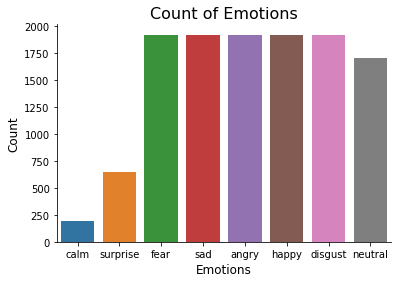

In [ ]:
plt.title('Count of Emotions', size=16)
sns.countplot(data_path.Emotions)
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

In [ ]:
def create_waveplot(data, sr, e):
    plt.figure(figsize=(10, 3))
    plt.title('Waveplot for audio with {} emotion'.format(e), size=15)
    librosa.display.waveplot(data, sr=sr)
    plt.show()

def create_spectrogram(data, sr, e):
    # stft function converts the data into short term fourier transform
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(12, 3))
    plt.title('Spectrogram for audio with {} emotion'.format(e), size=15)
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')   
    #librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar()

We can also plot waveplots and spectograms for audio signals

1. Waveplots - Waveplots let us know the loudness of the audio at a given time.

2. Spectograms - A spectrogram is a visual representation of the spectrum of frequencies of sound or other signals as they vary with time. It’s a representation of frequencies changing with respect to time for given audio/music signals.

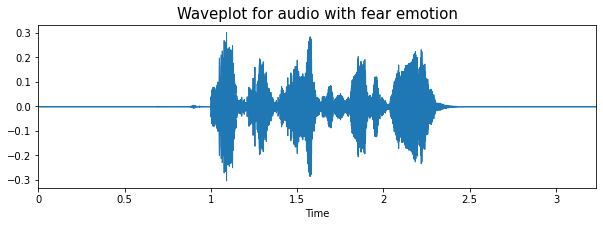

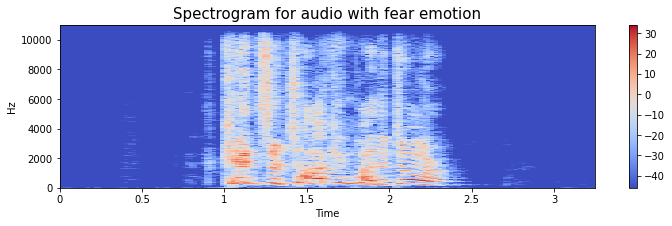

In [ ]:
emotion='fear'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

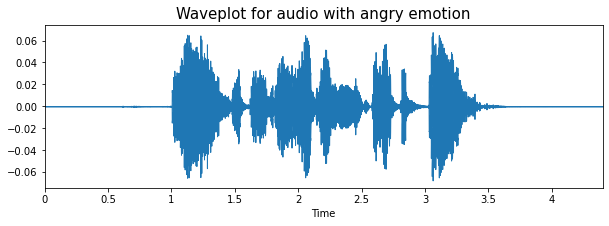

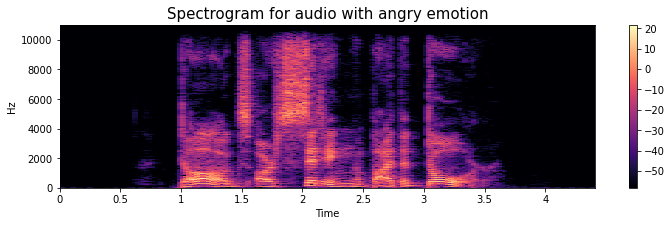

In [ ]:
emotion='angry'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

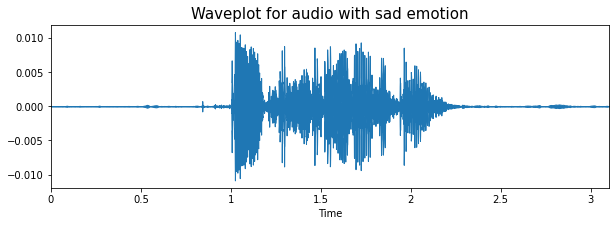

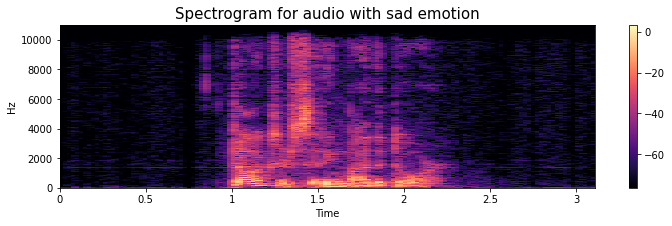

In [ ]:
emotion='sad'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

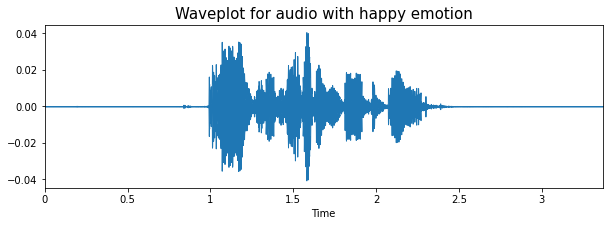

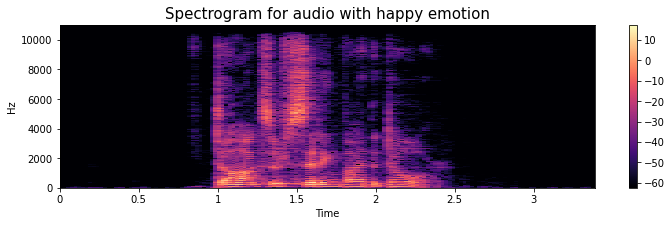

In [ ]:
emotion='happy'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

#Data Augmentation
To generate syntactic data for audio, we can apply noise injection, shifting time, changing pitch and speed.

In [ ]:
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate)
extract_features(data)
def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)

def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sampling_rate, pitch_factor)

# taking any example and checking for techniques.
path = np.array(data_path.Path)[1]
data, sample_rate = librosa.load(path)

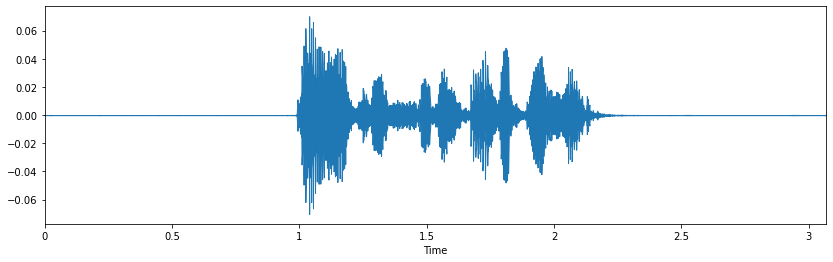

In [ ]:
plt.figure(figsize=(14,4))
librosa.display.waveplot(y=data, sr=sample_rate)
Audio(path)

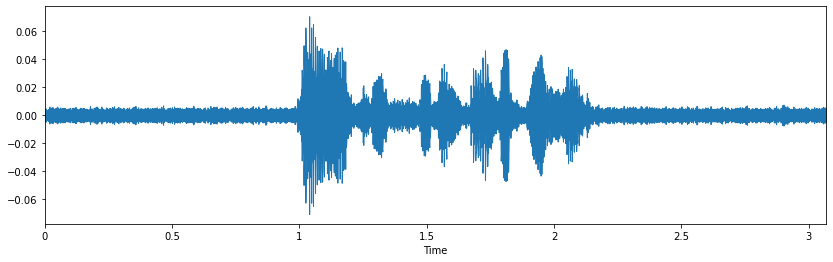

In [ ]:
x = noise(data)
plt.figure(figsize=(14,4))
librosa.display.waveplot(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

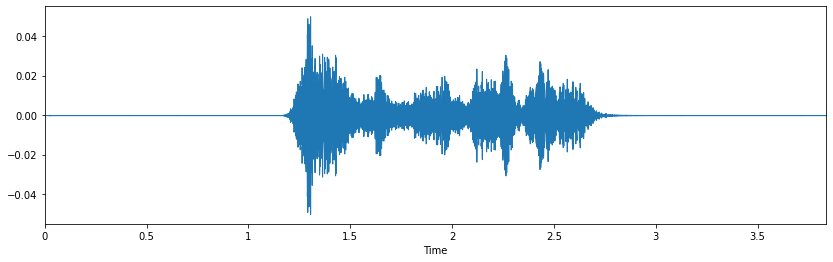

In [ ]:
x = stretch(data)
plt.figure(figsize=(14,4))
librosa.display.waveplot(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

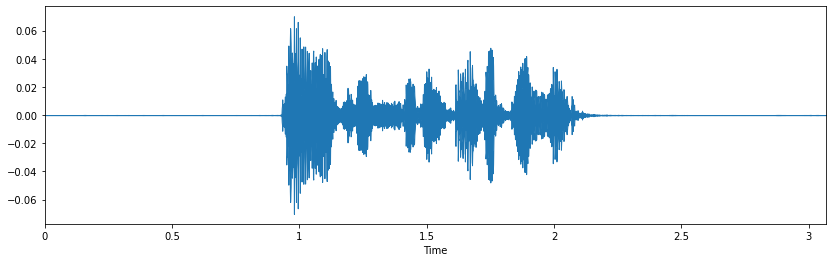

In [ ]:
x = shift(data)
plt.figure(figsize=(14,4))
librosa.display.waveplot(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

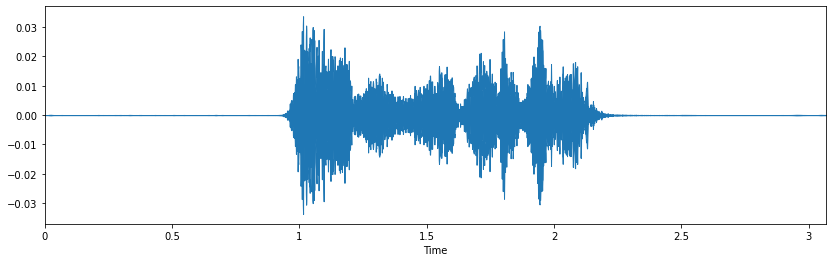

In [ ]:
x = pitch(data, sample_rate)
plt.figure(figsize=(14,4))
librosa.display.waveplot(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

The audio signal is a three-dimensional signal in which three axes represent time, amplitude and frequency.
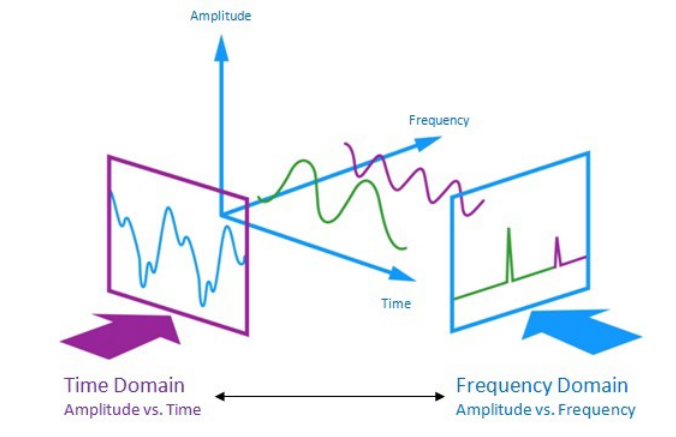

very good blog written by Askash Mallik on feature extraction.

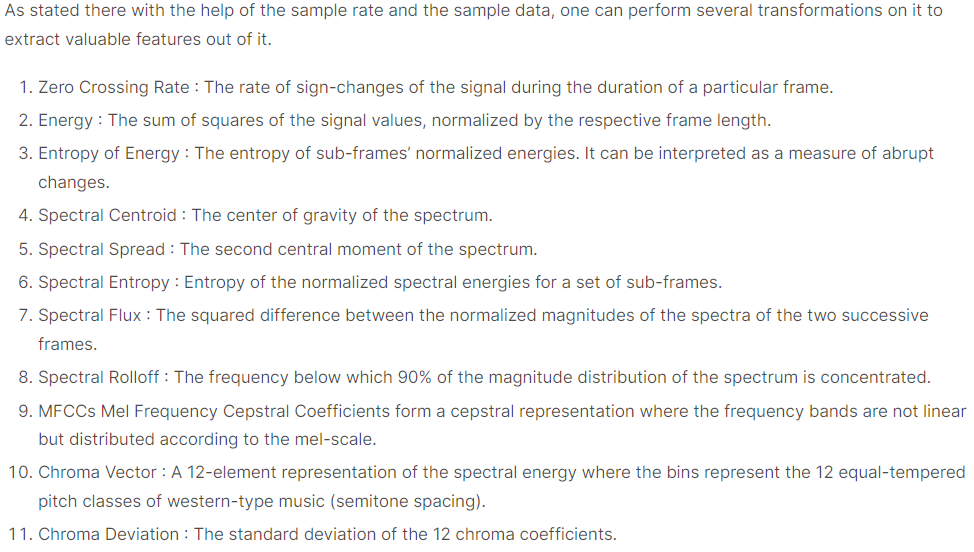

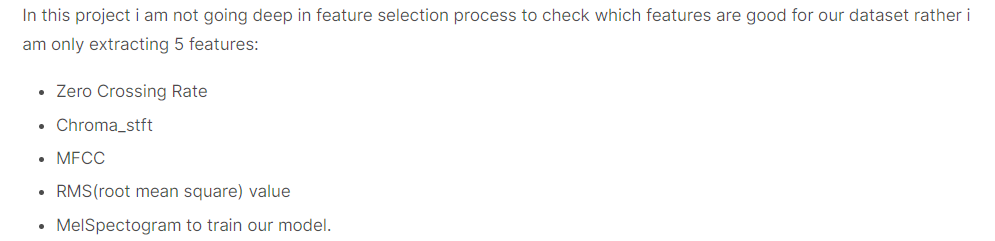

In [ ]:
def extract_features(data):
    # ZCR
    result = np.array([])
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    result=np.hstack((result, zcr)) # stacking horizontally

    # Chroma_stft
    stft = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    result = np.hstack((result, chroma_stft)) # stacking horizontally

    # MFCC
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mfcc)) # stacking horizontally

    # Root Mean Square Value
    rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
    result = np.hstack((result, rms)) # stacking horizontally

    # MelSpectogram
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mel)) # stacking horizontally
    
    return result

def get_features(path):
    # duration and offset are used to take care of the no audio in start and the ending of each audio files as seen above.
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)
    print(path,data, sample_rate)
    # without augmentation
    res1 = extract_features(data)
    result = np.array(res1)
    
    # data with noise
    noise_data = noise(data)
    res2 = extract_features(noise_data)
    result = np.vstack((result, res2)) # stacking vertically
    
    # data with stretching and pitching
    new_data = stretch(data)
    data_stretch_pitch = pitch(new_data, sample_rate)
    res3 = extract_features(data_stretch_pitch)
    result = np.vstack((result, res3)) # stacking vertically
    
    return result

In [ ]:
X, Y = [], []
for path, emotion in zip(data_path.Path, data_path.Emotions):
    feature = get_features(path)
    for ele in feature:
        X.append(ele)
        # appending emotion 3 times as we have made 3 augmentation techniques on each audio file.
        Y.append(emotion)

Streaming output truncated to the last 5000 lines.
 0.0000000e+00] 22050
/content/AudioWAV/1038_DFA_HAP_XX.wav [0.08550142 0.11468086 0.11225051 ... 0.         0.         0.        ] 22050
/content/AudioWAV/1002_DFA_FEA_XX.wav [-5.6568049e-03 -6.2881890e-03 -5.1340573e-03 ... -1.6859138e-05
 -2.7773356e-05  0.0000000e+00] 22050
/content/AudioWAV/1036_IEO_SAD_HI.wav [-2.7753732e-03 -3.0486444e-03 -1.9825152e-03 ...  2.2920551e-07
  3.1902354e-07  0.0000000e+00] 22050
/content/AudioWAV/1015_DFA_FEA_XX.wav [ 0.03808597  0.05097839  0.05010888 ... -0.00014041 -0.0001612
  0.        ] 22050
/content/AudioWAV/1022_DFA_FEA_XX.wav [-0.00780669 -0.00869947 -0.0054161  ...  0.          0.
  0.        ] 22050
/content/AudioWAV/1057_IEO_HAP_HI.wav [-0.11345869  0.0190699   0.1727475  ... -0.00039889 -0.00024673
  0.        ] 22050
/content/AudioWAV/1080_ITH_ANG_XX.wav [ 0.01185766  0.01302731  0.00936469 ...  0.00819368  0.00227406
 -0.00424509] 22050
/content/AudioWAV/1086_IOM_FEA_XX.wav [-6.2833

/usr/local/lib/python3.8/dist-packages/librosa/core/pitch.py:153: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn("Trying to estimate tuning from empty frequency set.")


Streaming output truncated to the last 5000 lines.
/content/TESS Toronto emotional speech set data/OAF_disgust/OAF_nice_disgust.wav [-0.05816102 -0.05507331 -0.03850085 ... -0.00011196 -0.00015876
  0.        ] 22050
/content/TESS Toronto emotional speech set data/OAF_disgust/OAF_met_disgust.wav [-3.7315099e-03 -8.6185848e-03 -1.2584872e-02 ...  3.2282111e-05
  1.6472518e-04  0.0000000e+00] 22050
/content/TESS Toronto emotional speech set data/OAF_disgust/OAF_hate_disgust.wav [-3.1895213e-02 -4.4741645e-02 -5.0435778e-02 ... -8.3620753e-06
 -2.3788707e-05  0.0000000e+00] 22050
/content/TESS Toronto emotional speech set data/OAF_disgust/OAF_goal_disgust.wav [ 2.8059112e-02  2.7512513e-02  1.8151769e-02 ... -1.0999099e-04
 -2.3366036e-05  0.0000000e+00] 22050
/content/TESS Toronto emotional speech set data/OAF_disgust/OAF_raid_disgust.wav [-4.6876448e-05  3.8760498e-03  1.3692698e-02 ... -1.1582743e-04
 -1.9781612e-04  0.0000000e+00] 22050
/content/TESS Toronto emotional speech set data/

In [ ]:

'''len(X), len(Y), data_path.Path.shape

Features = pd.DataFrame(X)
Features['labels'] = Y
Features.to_csv('features.csv', index=False)
Features.head()'''

0         1         2         3         4         5         6  \
0  0.175533  0.656951  0.558471  0.562335  0.603500  0.620426  0.589638   
1  0.193450  0.669954  0.582336  0.585695  0.648246  0.665853  0.627695   
2  0.163354  0.605862  0.582824  0.498256  0.529756  0.572691  0.591432   
3  0.241316  0.769143  0.751056  0.743346  0.723191  0.696938  0.676139   
4  0.349842  0.793341  0.794495  0.797440  0.833711  0.799934  0.700545   

          7         8         9  ...       153       154       155       156  \
0  0.570641  0.585851  0.534106  ...  0.000022  0.000019  0.000018  0.000012   
1  0.588822  0.605436  0.532703  ...  0.000023  0.000020  0.000019  0.000013   
2  0.564890  0.561891  0.565756  ...  0.000003  0.000005  0.000005  0.000004   
3  0.690442  0.702627  0.710791  ...  0.000045  0.000055  0.000061  0.000066   
4  0.711176  0.731412  0.733183  ...  0.000319  0.000349  0.000341  0.000346   

        157       158           159           160           161    labels  
0  0.000010  0.000005  8.768997e-07  7.680237e-08  1.114036e-09      calm  
1  0.000012  0.000006  2.036092e-06  1.134147e-06  1.064869e-06      calm  
2  0.000003  0.000001  3.282174e-07  1.624633e-08  7.418403e-11      calm  
3  0.000051  0.000040  9.750123e-06  9.181803e-07  9.894526e-09  surprise  
4  0.000343  0.000330  2.927861e-04  2.983766e-04  2.947212e-04  surprise  

[5 rows x 163 columns]

In [ ]:

import pandas as pd

Features = pd.read_csv('/content/gdrive/MyDrive/ml/SpeechEmotionRecognition/features.csv')
Features.head()

0         1         2         3         4         5         6  \
0  0.175533  0.656951  0.558471  0.562335  0.603500  0.620426  0.589638   
1  0.193450  0.669954  0.582336  0.585695  0.648246  0.665853  0.627695   
2  0.163354  0.605862  0.582824  0.498256  0.529756  0.572691  0.591432   
3  0.241316  0.769143  0.751056  0.743346  0.723191  0.696938  0.676139   
4  0.349842  0.793341  0.794495  0.797440  0.833711  0.799934  0.700545   

          7         8         9  ...       153       154       155       156  \
0  0.570641  0.585851  0.534106  ...  0.000022  0.000019  0.000018  0.000012   
1  0.588822  0.605436  0.532703  ...  0.000023  0.000020  0.000019  0.000013   
2  0.564890  0.561891  0.565756  ...  0.000003  0.000005  0.000005  0.000004   
3  0.690442  0.702627  0.710791  ...  0.000045  0.000055  0.000061  0.000066   
4  0.711176  0.731412  0.733183  ...  0.000319  0.000349  0.000341  0.000346   

        157       158           159           160           161    labels  
0  0.000010  0.000005  8.768997e-07  7.680237e-08  1.114036e-09      calm  
1  0.000012  0.000006  2.036092e-06  1.134147e-06  1.064869e-06      calm  
2  0.000003  0.000001  3.282174e-07  1.624633e-08  7.418403e-11      calm  
3  0.000051  0.000040  9.750123e-06  9.181803e-07  9.894526e-09  surprise  
4  0.000343  0.000330  2.927861e-04  2.983766e-04  2.947212e-04  surprise  

[5 rows x 163 columns]

In [ ]:
#Make a copy:
newdFeatures = Features.copy()

In [ ]:
# Applying the condition
newdFeatures.loc[newdFeatures["labels"] == "calm", "labels"] = "good"
newdFeatures.head()

0         1         2         3         4         5         6  \
0  0.175533  0.656951  0.558471  0.562335  0.603500  0.620426  0.589638   
1  0.193450  0.669954  0.582336  0.585695  0.648246  0.665853  0.627695   
2  0.163354  0.605862  0.582824  0.498256  0.529756  0.572691  0.591432   
3  0.241316  0.769143  0.751056  0.743346  0.723191  0.696938  0.676139   
4  0.349842  0.793341  0.794495  0.797440  0.833711  0.799934  0.700545   

          7         8         9  ...       153       154       155       156  \
0  0.570641  0.585851  0.534106  ...  0.000022  0.000019  0.000018  0.000012   
1  0.588822  0.605436  0.532703  ...  0.000023  0.000020  0.000019  0.000013   
2  0.564890  0.561891  0.565756  ...  0.000003  0.000005  0.000005  0.000004   
3  0.690442  0.702627  0.710791  ...  0.000045  0.000055  0.000061  0.000066   
4  0.711176  0.731412  0.733183  ...  0.000319  0.000349  0.000341  0.000346   

        157       158           159           160           161    labels  
0  0.000010  0.000005  8.768997e-07  7.680237e-08  1.114036e-09      good  
1  0.000012  0.000006  2.036092e-06  1.134147e-06  1.064869e-06      good  
2  0.000003  0.000001  3.282174e-07  1.624633e-08  7.418403e-11      good  
3  0.000051  0.000040  9.750123e-06  9.181803e-07  9.894526e-09  surprise  
4  0.000343  0.000330  2.927861e-04  2.983766e-04  2.947212e-04  surprise  

[5 rows x 163 columns]

In [ ]:
newdFeatures.loc[newdFeatures["labels"] == "surprise", "labels"] = "good"
newdFeatures.loc[newdFeatures["labels"] == "happy", "labels"] = "good"
newdFeatures.loc[newdFeatures["labels"] == "neutral", "labels"] = "good"

newdFeatures.loc[newdFeatures["labels"] == "fear", "labels"] = "bad"
newdFeatures.loc[newdFeatures["labels"] == "sad", "labels"] = "bad"
newdFeatures.loc[newdFeatures["labels"] == "disgust", "labels"] = "bad"
newdFeatures.loc[newdFeatures["labels"] == "angry", "labels"] = "bad"

In [ ]:
X = newdFeatures.iloc[: ,:-1].values
Y = newdFeatures['labels'].values

In [ ]:
newdFeatures['labels'].unique()

array(['good', 'bad'], dtype=object)

In [ ]:
# As this is a multiclass classification problem onehotencoding our Y.
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

In [ ]:
# splitting data
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=0, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((27364, 162), (27364, 2), (9122, 162), (9122, 2))

In [ ]:
# scaling our data with sklearn's Standard scaler
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((27364, 162), (27364, 2), (9122, 162), (9122, 2))

In [ ]:
# making our data compatible to model.
x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((27364, 162, 1), (27364, 2), (9122, 162, 1), (9122, 2))

In [ ]:
model=Sequential()
model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(x_train.shape[1], 1)))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
model.add(Dropout(0.75))

model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
model.add(Dropout(0.75))

model.add(Conv1D(64, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(BatchNormalization())#
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Flatten())
model.add(Dense(units=32, activation='relu'))
model.add(BatchNormalization())

model.add(Dense(units=2, activation='softmax'))
model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_4 (Conv1D)           (None, 162, 256)          1536      
                                                                 
 batch_normalization_5 (Batc  (None, 162, 256)         1024      
 hNormalization)                                                 
                                                                 
 max_pooling1d_4 (MaxPooling  (None, 81, 256)          0         
 1D)                                                             
                                                                 
 dropout_2 (Dropout)         (None, 81, 256)           0         
                                                                 
 conv1d_5 (Conv1D)           (None, 81, 256)           327936    
                                                                 
 batch_normalization_6 (Batc  (None, 81, 256)         

In [ ]:
#model = keras.models.load_model('/content/SpeechEmotionRecognition_200_77.h5')

In [ ]:
rlrp = ReduceLROnPlateau(monitor='loss', factor=0.4, verbose=0, patience=2, min_lr=0.0000001)
history=model.fit(x_train, y_train, batch_size=64, epochs=200, validation_data=(x_test, y_test), callbacks=[rlrp])

Epoch 1/200
428/428 [==============================] - 16s 15ms/step - loss: 0.6255 - accuracy: 0.6536 - val_loss: 0.6866 - val_accuracy: 0.5880 - lr: 0.0010
Epoch 2/200
428/428 [==============================] - 6s 14ms/step - loss: 0.5627 - accuracy: 0.7014 - val_loss: 0.6079 - val_accuracy: 0.6871 - lr: 0.0010
Epoch 3/200
428/428 [==============================] - 6s 14ms/step - loss: 0.5429 - accuracy: 0.7109 - val_loss: 0.5503 - val_accuracy: 0.7212 - lr: 0.0010
Epoch 4/200
428/428 [==============================] - 6s 14ms/step - loss: 0.5254 - accuracy: 0.7228 - val_loss: 0.5051 - val_accuracy: 0.7273 - lr: 0.0010
Epoch 5/200
428/428 [==============================] - 6s 14ms/step - loss: 0.5135 - accuracy: 0.7266 - val_loss: 0.5427 - val_accuracy: 0.7131 - lr: 0.0010
Epoch 6/200
428/428 [==============================] - 6s 14ms/step - loss: 0.5090 - accuracy: 0.7277 - val_loss: 0.4989 - val_accuracy: 0.7348 - lr: 0.0010
Epoch 7/200
428/428 [==============================] - 6s

In [ ]:

#rlrp = ReduceLROnPlateau(monitor='loss', factor=0.4, verbose=0, patience=2, min_lr=0.0000001)
#history=model.fit(x_train, y_train, batch_size=64, epochs=200, validation_data=(x_test, y_test), callbacks=[rlrp])

In [ ]:
model.save('SpeechEmotionRecognition_200_Good_bad_82.h5')

In [ ]:
#model = keras.models.load_model('/content/SpeechEmotionRecognition_200.h5')

286/286 [==============================] - 1s 4ms/step - loss: 0.4229 - accuracy: 0.8247
Accuracy of our model on test data :  82.47094750404358 %


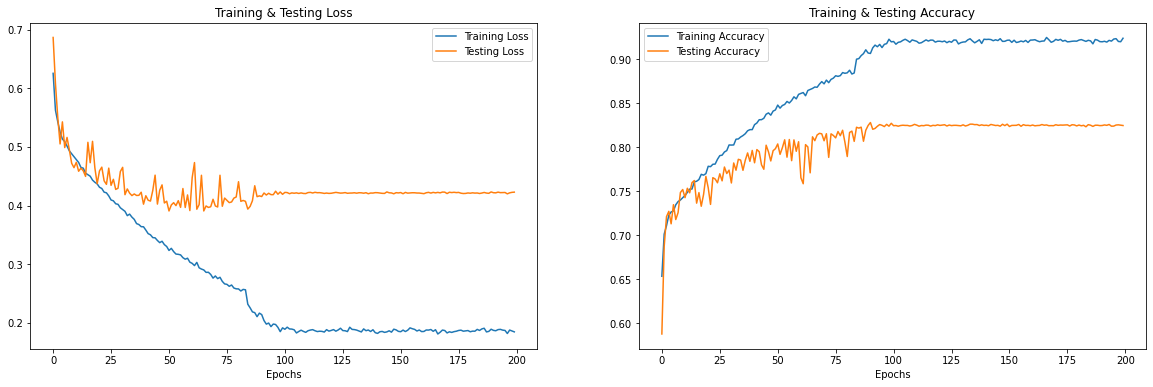

In [ ]:
print("Accuracy of our model on test data : " , model.evaluate(x_test,y_test)[1]*100 , "%")

epochs = [i for i in range(200)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

In [ ]:
# predicting on test data.
pred_test = model.predict(x_test)
y_pred = encoder.inverse_transform(pred_test)

y_test = encoder.inverse_transform(y_test)

286/286 [==============================] - 1s 3ms/step


In [ ]:
df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred.flatten()
df['Actual Labels'] = y_test.flatten()

df.head(10)

Predicted Labels Actual Labels
0             good           bad
1             good          good
2             good          good
3              bad           bad
4              bad           bad
5              bad          good
6              bad           bad
7              bad           bad
8              bad           bad
9             good          good

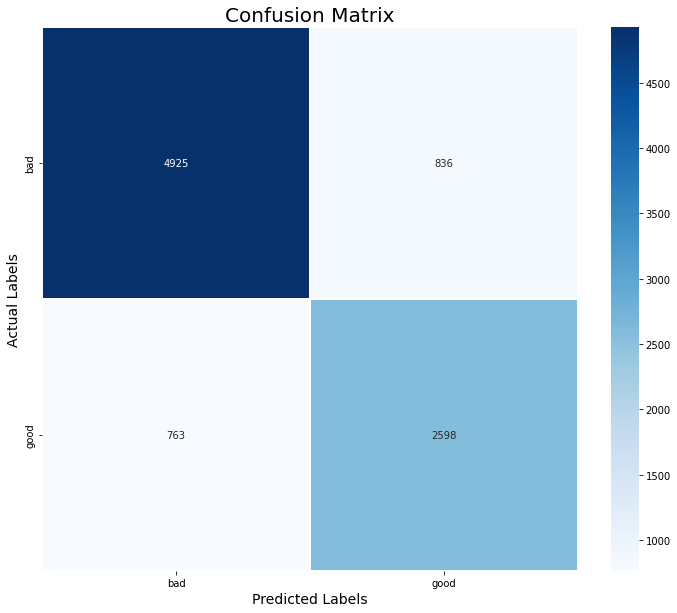

In [ ]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         bad       0.87      0.85      0.86      5761
        good       0.76      0.77      0.76      3361

    accuracy                           0.82      9122
   macro avg       0.81      0.81      0.81      9122
weighted avg       0.83      0.82      0.83      9122

